# Course: Advanced Methods in Applied Statistics {-}
# Author: Kiril Klein (UCPH-ID: fjn197) {-}
I, Kiril Klein expressly vow to uphold my scientific, academic, and moral integrity by working individually on this exam and soliciting no direct external help or assistance.

In [4]:
import sys
sys.path.append('../')

In [ ]:
#import warnings
#warnings.filterwarnings("ignore")
#%config Completer.use_jedi = False

In [491]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import toolbox as tb
from toolbox import fits, vis
from toolbox import as_toolbox as ast
from toolbox.vis import Color_palette as Color_p
import urllib
from scipy import stats
from scipy import optimize
from toolbox.ExternalFunctions import NLLH
import importlib
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nestle
#from numba import jit
#from mayavi import mlab
#import nestle
#import corner
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#import dtale

# Problem 1 {-}

A maximum likelihood fit was performed to estimate best-fit parameters. The data was then binned using 50 bins from the minimal to the maximal value of the range. Binned data was used to compute a $\chi^2$ value and to detemine the correpsonding p-value. A function is rejected if the p-value is below 0.05.

In [422]:
url = "https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/data/Exam_2021_Prob1.txt"
D1 = pd.read_csv(url, sep=r" ", header = None, engine='python')

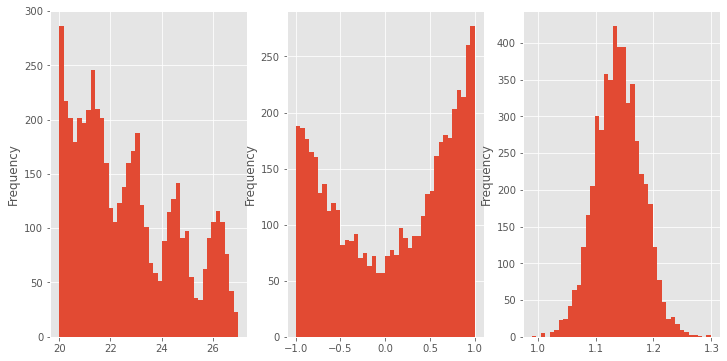

In [424]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(1,3, figsize = (12,6))
ax = ax.flatten()
for i,j in enumerate([0,1,3]):
    D1.iloc[:,j].plot.hist(legend=False, bins = 40, ax = ax[i])

In [614]:
#Test all 3 pdfs for the first column
def f0(x, a,b,c):
    xmax = 27
    xmin = 20
    Norm = -1/a*(np.cos(a*xmax)-np.cos(a*xmin)) + c/b*(np.exp(b*xmax)-np.exp(b*xmin)) 
    return (np.sin(a*x)+c*np.exp(b*x)+1)/Norm

def f1(x, a, b): return (1+ a*x + b*x**2)/(2+2/3*b)
#For the third column we have poisson, binomial, maybe logarithmic
def f3(x, a, b): return stats.norm.pdf(x, loc = a, scale = b)

def f_chi2(O, E): return np.sum((O-E)**2/E)

## col 0 

In [613]:
x0 = np.linspace(20,27,100)
fd0 = vis.nice_histogram(D1.iloc[:,0], 50)
p0 = [4.15,-.3,4000]
fig, ax = vis.nice_plot(x0, f0(x0, *p0)*len(D1)*fd0['binwidth'], figure = fd0['fig'], axis = fd0['ax'])
fig

TypeError: f0() takes 3 positional arguments but 4 were given

In [548]:
f_nllh(1,1,1)

22174.57863542423

In [604]:
importlib.reload(ast)

<module 'toolbox.as_toolbox' from '..\\toolbox\\as_toolbox.py'>

In [616]:
f_nllh = ast.NLLH(f0, D1.iloc[:,0])

def f_llikelihood(T):
    t1, t2, t3 = T
    nllh = f_nllh(t1,t2)
    return -nllh
def prior_transform(x):
    return np.array([20 * x[0] - 10 , 20 * x[1]-10, 4000*x[2]+4000])

In [617]:
#for some reason nested sampling is too slow
result = nestle.sample(
    f_llikelihood, prior_transform, 2, method = 'multi', npoints = 100)
logz = result.logz     # log evidence
logzerr = result.logzerr  # numerical (sampling) error on logz
samples = result.samples  # array of sample parameters
weights = result.weights  # array of weights associated with each sample
logl = result.logl
print(result.summary())

IndexError: index 2 is out of bounds for axis 0 with size 2

In [607]:
def Neg_llh(x): return f_nllh(x[0],x[1],x[2])
ret_dict = optimize.minimize(Neg_llh, x0 = [4,-.32,4500], 
                               bounds= [(-10,10), (-10,10),(4000,8000)])
ret_dict

TypeError: f0() takes 3 positional arguments but 4 were given

In [618]:
#lets try MCMC
f_nllh = ast.NLLH(f0, D1.iloc[:,0])
num_iter = 10
def loglikelihood(a,b,c): return -f_nllh(a,b,c)
def prop(size): return stats.norm.rvs(loc = [0,0,0], scale = [.1,.1,10], size = size)
p0 = stats.norm.rvs(loc = [5,-.3,5000], scale = [.5,.5,10], size = 3)
P_trace = np.empty((num_iter,3))
for i in range(num_iter):
        p_prop = p0+prop(size = 3)
        rand = np.random.uniform()
        if (np.exp(loglikelihood(*p_prop)) / np.exp(loglikelihood(*p0) ))>rand:
            p0 = p_prop
        else:
            pass
        P_trace[i,:] = p0

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [619]:
importlib.reload(ast)

<module 'toolbox.as_toolbox' from '..\\toolbox\\as_toolbox.py'>

In [610]:
#fix c at 4000 and perform maximum likelihood scan
NLLH2d = ast.NLLH_scan(f0, D1.iloc[:,0])
grid, llh2d = NLLH2d(np.linspace(-10,10),np.linspace(-10,10))
fig, ax = plt.subplots()
ax.contourf(grid[0], grid[1], llh2d, 100)

..\toolbox\as_toolbox.py:424: RuntimeWarning: invalid value encountered in log
  logf = np.log(f)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  


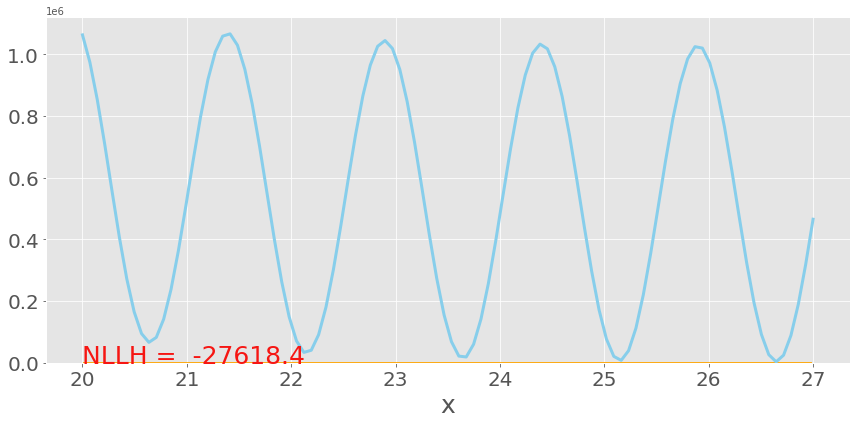

In [611]:
#Lets perform likelihood fits for the functions that might be suitable
def f0(x, a,b):
    c = 4000
    xmax = 27
    xmin = 20
    Norm = -1/a*(np.cos(a*xmax)-np.cos(a*xmin)) + c/b*(np.exp(b*xmax)-np.exp(b*xmin)) 
    return (np.sin(a*x)+c*np.exp(b*x)+1)/Norm

p0 = [4.15,-.3]
nbins = 50

dt0 = fits.hist_fit(
    f0, D1.iloc[:,0], p0, fit_type = 'ullh',
    observed = True, print_level = 0)
a0m, b0m = dt0['minuit_obj'].values[:]
fd0 = vis.nice_histogram(D1.iloc[:,0], 50)

fig, ax = vis.nice_plot(
    x0, f0(x0, a0m, b0m)*len(D1)*fd0['binwidth'], 
    figure = fd0['fig'], axis = fd0['ax'])
#Both seem to fit reasonably well
LLH0 = dt0['minuit_obj'].fval
ax.text(20, 10, f"NLLH =  {LLH0:2.1f}", color = Color_p(2)[0],fontsize = 25)
fig

## Col1 

In [ ]:
x1 = np.linspace(-1,1,100)
fd1 = vis.nice_histogram(D1.iloc[:,1], 50)
p1 = [1,1]
fig, ax = vis.nice_plot(x1, f1(x1, *p1)*len(D1)*fd1['binwidth'], figure = fd1['fig'], axis = fd1['ax'])

In [ ]:
#Lets perform likelihood fits for the functions that might be suitable
nbins = 50
dt1 = fits.hist_fit(
    f1, D1.iloc[:,1], p1, fit_type = 'ullh',
    observed = True, print_level = 0)
a1m, b1m = dt1['minuit_obj'].values[:]
sa1m, sb1m = dt1['minuit_obj'].errors[:]
fd1 = vis.nice_histogram(D1.iloc[:,1], 50, data_label_hist='Data')
p00 = [4.2,-.11,40]
fig, ax = vis.nice_plot(
    x1, f1(x1, a1m, b1m)*len(D1)*fd1['binwidth'],  plot_legend=True, label_fs=25,
    figure = fd1['fig'], axis = fd1['ax'], data_label = r"$\propto 1+ax+bx^2$")
#Both seem to fit reasonably well
LLH1 = dt1['minuit_obj'].fval
ax.text(0, 210, f"NLLH =  {LLH1:2.1f}", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 170, r"$a = 0.47\pm0.05$", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 150, r"$b = 2.58\pm0.16$", color = Color_p(2)[0],fontsize = 25)
#compute chi2 and pvalue using 50 bins
chi21 = f_chi2(fd1['y'], f1(fd1['x'],a1m, b1m))
pval1 = stats.chi2.sf(chi21, len(D1)-2)
ax.text(0, 190, r"$p = 0.680$", color = Color_p(2)[0],fontsize = 25)
fig

In [ ]:
pval1

## Col 3

In [ ]:
x3 = np.linspace(0,2.5,100)
fd3 = vis.nice_histogram(D1.iloc[:,3], 50)
p3 = [1.12,.04]
fig, ax = vis.nice_plot(x3, f3(x3, *p3)*len(D1)*fd3['binwidth'], figure = fd3['fig'], axis = fd3['ax'])
fig

In [ ]:
#Lets perform likelihood fits for the functions that might be suitable
nbins = 50
dt3 = fits.hist_fit(
    f3, D1.iloc[:,3], p3, fit_type = 'ullh',
    observed = True, print_level = 0)
a3m, b3m = dt3['minuit_obj'].values[:]
sa3m, sb3m = dt3['minuit_obj'].errors[:]
fd3 = vis.nice_histogram(D1.iloc[:,3], 50, data_label_hist='Data',label_fs=25)
fig, ax = vis.nice_plot(
    x3, f3(x3, a3m, b3m)*len(D1)*fd3['binwidth'],  plot_legend=True,
    figure = fd3['fig'], axis = fd3['ax'], data_label = r"$\propto \exp{( -\frac{(x-a)^2}{2b^2})  }$")
#Both seem to fit reasonably well
LLH3 = dt3['minuit_obj'].fval
ax.text(0, 210, f"NLLH =  {LLH1:2.1f}", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 180, r"$a = 1.1396\pm0.0006$", color = Color_p(2)[0],fontsize = 25)
ax.text(0, 150, r"$b = 0.0396\pm0.0004$", color = Color_p(2)[0],fontsize = 25)
fig

# Problem 2 {-} 

## Problem 2a {-}

Running 10000 pseudo-experiments in producing isotropic points on a unit sphere will be used to determine a test statistic for the KS-value. This will then be used to determine whether the data follows uniform distribution in $\varphi$ and $\cos{(\theta)}$. 

In [ ]:
url = "https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/data/Exam_2021_Problem2.txt"
D2 = np.loadtxt(url , skiprows = 2)
d_phi = D2[:,0]#azimuth angle from 0 to 2*pi
d_theta = D2[:,1]#zenith angle from 0 to pi

In [ ]:
plt.figure(figsize = (6,6))
plt.subplot(projection="hammer")
plt.scatter(d_phi-np.pi, d_theta-np.pi/2,  s=10, c='r', zorder=10)
plt.grid(True)
plt.tight_layout()
#Is this uniform? 

In [ ]:
#Autocorrelation for data
Npoints = len(D2)
nphi = 50
d_3d = ast.create_points3d(d_phi, d_theta)
x_phi = np.linspace(0, 2*np.pi,nphi)
iso = ast.f_isotropic(x_phi)#isotropic for large number of events
CAR_data = ast.cumulative_autocorrelation(d_3d, x_phi)
fig, ax = vis.nice_plot(
    np.cos(x_phi), CAR_data, drawstyle = 'steps-mid',
    xlabel = r"$\cos{\varphi}$", ylabel = r"$\mathcal{C(\varphi)}$")

In [ ]:
import importlib
_=importlib.reload(ast)

In [ ]:
#Produce pseudo experiments
Nexp = int(500)
#accelerate with numba
#@jit(forceobj = True)
def simulate_KS(Nexp):
    KS_iso = np.empty(Nexp)
    for i in range(Nexp):
        X_iso = ast.sample_spherical_uniform(Npoints)
        KS_iso[i] = np.max(np.abs(ast.cumulative_autocorrelation(X_iso, x_phi)-iso))
    return KS_iso

In [ ]:
KS_iso = simulate_KS(Nexp)
KS_data = np.max(np.abs(CAR_data-iso))

In [ ]:
fd = vis.nice_histogram(
    KS_iso, 100, data_label_hist='isotropic', xlabel = 'KS',
    plot_legend=True)
fd['ax'].axvline(KS_data, label = 'data')
fd['ax'].legend(fontsize = 25)
fd['fig']

In [ ]:
#compute integral
KSx, KSy = fd['x'], fd['y']
data_mask = KSx>KS_data
integral_abs = np.sum(KSy[data_mask])
integral_iso = integral_abs/np.sum(KSy)
print(integral_iso)

The integral is 0.0044 which corresponds to the p-value. We can reject the isotropic hypothesis for the data.

## Problem 2b {-} 

In [ ]:
Nexp = 10
Nuniform = int(Npoints*0.8)
Nha = int(Npoints*0.2)
aphi = np.random.uniform(size = Nha)*(0.725-0.225)*np.pi + 0.225*np.pi
atheta = np.random.uniform(size = Nha)*(1-0.3)*np.pi + 0.3*np.pi
#@jit(forceobj = True)
def simulate_KS_HA(Nexp):
    KS_HA = np.empty(Nexp)
    iso = ast.f_isotropic(x_phi)
    for i in range(Nexp):
        X_HA = ast.create_points3d(aphi, atheta)
        X_iso = ast.sample_spherical_uniform(Nuniform)
        X_HA = np.concatenate((X_HA, X_iso), axis = 1)
        KS_HA[i] = np.max(np.abs(ast.cumulative_autocorrelation(X_HA, x_phi)-iso))
    return KS_HA

In [ ]:
%time KS_HA = simulate_KS_HA(100)

In [ ]:
fdA = vis.nice_histogram(
    KS_HA, 100, data_label_hist='Hypotheses A', xlabel = 'KS',
    plot_legend=True)
fdA['ax'].axvline(KS_data, label = 'data')
fdA['ax'].legend(fontsize = 25)
fdA['fig']

In [ ]:
#compute integral
KSx, KSy = fdA['x'], fdA['y']
data_mask = KSx>KS_data
integral_abs = np.sum(KSy[data_mask])
integral_iso = integral_abs/np.sum(KSy)
print(integral_iso)

In [ ]:
Nexp = 10
NuniformB = int(Npoints*0.85)
NHB = int(Npoints*0.15)
bphi = np.random.uniform(size = NHB)*np.pi 
btheta = np.random.uniform(size = NHB)*0.5*np.pi + 0.5*np.pi
@jit(forceobj = True)
def simulate_KS_HB(Nexp):
    KS_HB = np.empty(Nexp)
    iso = ast.f_isotropic(x_phi)
    for i in range(Nexp):
        X_HB = ast.create_points3d(bphi, btheta)
        X_iso = ast.sample_spherical_uniform(Nuniform)
        X_HB = np.concatenate((X_HB, X_iso), axis = 1)
        KS_HB[i] = np.max(np.abs(ast.cumulative_autocorrelation(X_HB, x_phi)-iso))
    return KS_HB
KS_HB = simulate_KS_HB(100)
fdB = vis.nice_histogram(
    KS_HB, 100, data_label_hist='Hypotheses A', xlabel = 'KS',
    plot_legend=True)
fdB['ax'].axvline(KS_data, label = 'data')
fdB['ax'].legend(fontsize = 25)
fdB['fig']

In [ ]:
#compute integral
KSx, KSy = fdB['x'], fdB['y']
data_mask = KSx>KS_data
integral_abs = np.sum(KSy[data_mask])
integral_iso = integral_abs/np.sum(KSy)
print(integral_iso)

# Problem 3 {-} 

## Problem 3a {-} 

In [121]:
X0test = X0[-4:,:]
#lets measure distances in meters
dist = 200
R = 5e3
def polar_to_cart(r, phi):
    x = np.cos(phi)*r
    y = np.sin(phi)*r
    return x, y
def cart_to_polar(x,y):
    phi = np.sign(y)*(np.arctan(y/x)+np.pi/2)
    r = x**2 + y**2
    return r, phi

def update_coordinates(X0):
    """samples random unit vector in 2d and adds it to the current vector"""
    X_step = ast.sample_spherical_uniform(len(X0), 2).T
    return X0+X_step
def measure_dist(X):
    """Upper triangular contains the distances, 
    lower triangular and diagonal are set to inf"""
    x, y = X[:,0],X[:,1]
    xxa, xxb  = np.meshgrid(x, x)
    yya, yyb = np.meshgrid(y,y)
    Dist = np.sqrt( (xxa-xxb)**2+(yya-yyb)**2 ) #distance matrix
    Dist = np.triu(Dist)#we want the distance only once
    mask0 = Dist==0.
    Dist[mask0] = np.inf 
    battle_indices = np.argwhere(Dist<=175)
    return battle_indices
#def battle(list_of_pairs):
    
#def ():
 #   pass

In [208]:
Start = np.array([3600, -2000])
Start_all = np.repeat(Start[:,np.newaxis], Nexp, axis=1).T
ast.sample_spherical_uniform(1, 2).T*200

200.0

In [174]:
ast.sample_spherical_uniform(1, 2).shape

(2, 1)

In [205]:
Start_all[0,:]

array([0, 0])

In [ ]:
Nexp = 2
Start = np.array([3600, -2000])
Start_all = np.repeat(Start[:,np.newaxis], Nexp, axis=1).T
Distance_travelled = np.zeros(Nexp)
Dist_from_origin = np.zeros(Nexp)
for i in range(Nexp):
    while (Dist_from_origin[i]<R) and (Distance_travelled[i]<10000):
        Start_all[i,:] = Start_all[i,:] + ast.sample_spherical_uniform(1, 2).T
        Dist_from_origin[i] = np.linalg.norm(Start_all[i,:])
        Distance_travelled[i] += 1. 

In [204]:
Nexp = 2
Ndays = 200
Start = np.array([3600, -2000])
Start_all = np.repeat(Start[:,np.newaxis], Nexp, axis=1).T
Distance_travelled = np.zeros(Nexp)
Dist_from_origin = np.zeros(Nexp) 
def run_exp(Start_all):
    Distance_travelled = np.zeros(Nexp)
    X = Start_all
    for i in range(Ndays):
        X = update_coordinates(X)
        Dist_from_origin = np.linalg.norm(X, axis = 1)
        mask_edge = Dist_from_origin>=R
        Distance_travelled[mask_edge] = float(i)
        X[mask_edge,:] = 0
    return Distance_travelled, X

## Problem 3b {-} 

In [137]:
url = "https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/data/Exam_2021_Prob3_CrabStartPositions.txt"
X0 = np.loadtxt(url , skiprows = 0)*1e3

# Problem 4 {-} 

In [330]:
Ndays = 500
Asold = 5
lam_lost = 23
mu_A = 240
sig_A = 10
Nhours = 10
Trading_time = []#np.empty(Ndays)
A = np.zeros((Ndays, Nhours))
#simulating is one choice, maybe better to look at the pdfs
for i in range(Ndays):
    A0 = 412
    for j in range(Nhours):
        A[i,j] = A0
        p_exch = stats.norm.pdf(A0, loc = mu_A, scale = sig_A)
        if p_exch>np.random.uniform():
            Trading_time.append(j)
            break
        A0 -= (stats.poisson.rvs(lam_lost)+Asold)
Trading_time = np.array(Trading_time)

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


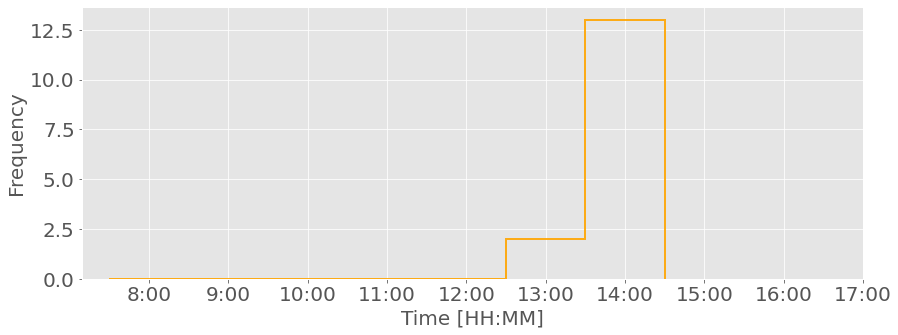

In [336]:
bins = np.arange(-.5,Trading_time.max()+.5)#shift bins
labels = ['8:00','9:00', '10:00', '11:00', '12:00', '13:00', 
          '14:00', '15:00', '16:00', '17:00','18:00']
fd = vis.nice_histogram(np.array(Trading_time), bins, 
                        xlabel='Time [HH:MM]', figsize = (14,5))
fd['ax'].set_xticklabels(labels)
fd['ax'].set_xticks(np.arange(0,10))
fd['fig']

N pseudo-experiments were run, drawing random numbers from the poisson distribution to determine the amount of lost fish and trade with a probability described by the prior.

In [377]:
#The probability for lossing N fish after t hours is given by:
def p_loose(N_lost, t): return stats.poisson.pmf(N_lost, t*lam)
def flikelihood_left(N_left, t): 
    N_sold = t*5
    N_lost = 412 - N_left - N_sold
    return p_loose(N_lost,t)
def fprior_exch(N_left):
    return stats.norm.pdf(N_left, 240, 10)
def fposterior(N_left, t):
    return flikelihood_left(N_left,t)*fprior_exch(N_left)

In [388]:
hours = np.arange(10)
fish_arr = np.arange(0,412)
Posterior_landscape =[]
for i in hours:
    Posterior_landscape.append(fposterior(fish_arr, i))
Posterior_landscape = np.array(Posterior_landscape)

In [411]:
np.sum(Posterior_landscape.T, axis = 0)

array([0.00000000e+00, 6.56974093e-36, 1.26466603e-20, 1.47661251e-11,
       3.55865849e-06, 2.57114823e-03, 2.48863391e-02, 8.25227680e-03,
       1.76926605e-04, 3.85958585e-07])

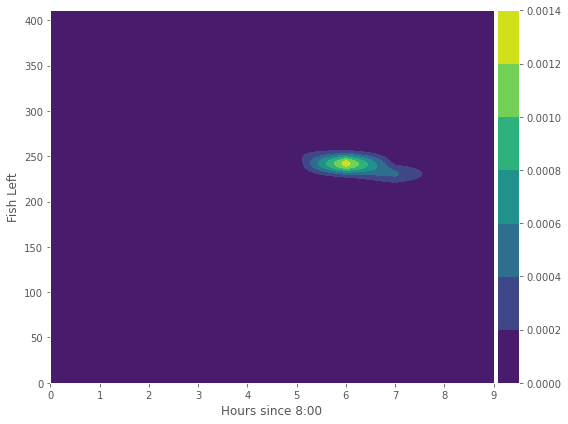

In [418]:
hh, ff = np.meshgrid(hours, fish_arr)
fig, ax= plt.subplots(figsize = (8,6))
im = ax.contourf(hh, ff, Posterior_landscape.T)
ax.set_xlabel('Hours since 8:00')
ax.set_ylabel('Fish Left')
divider = make_axes_locatable(ax)
cax0 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax0)
fig.tight_layout()
fig.savefig('Figs/P4a_posterior.png', dpi = 80)

In [ ]:
money0 = t0*6*5
money1 = (T-t0)*10*3
B_left = 120-
money2 = B_left*4
Money = money0 + money1 + money2

In [ ]:
t0 = money/6/5
t0 = T-money1/10/3
B_sold = (T-t0)*3
B_lost = 120 - B_left - B_sold

In [ ]:
def flikelihood_leftB(B_left, t0):
    B_lost = 120-B_left-(T-t0)*3
    return p_loose(B_lost, t1)

[Title](Figs/P4a_posterior.png)

In [420]:
xaxis = np.arange(100,300)
#vis.nice_plot(xaxis, , scatter=True)

In [355]:
likelihood_left(389, 1)

0.05199803646987484

# Problem 5 {-}